# overview plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sstats.hfreq as hf
import sstats.tseries as ts

rad = 2*np.pi

print_figs = True

In [2]:
# utils

def add_omegas(ax, refs, y=0.02, lw=2, color="#1f77b4"):
    """ Add reference frequencies
    """
    for r in refs:
        omega, label = r
        ax.axvline(omega, ls="--", lw=lw, color=color)
        ax.text(omega*1.2, y, label, fontsize=15, color=color)

---

## Low frequency signal

In [3]:
u = hf.low_frequency_signal()

In [4]:
u.autocorrelation

U**2*exp(-tau/T)

In [5]:
u.spectrum

2*T*U**2/(T**2*omega**2 + 1)

In [6]:
# check Parseval: !!! 2 pi factor required
from sympy import oo, pi
u.spectrum.integrate((u.omega, -oo, oo)) /2/pi

U**2

In [7]:
# value at 0 frequency
u.spectrum.subs({u.omega:0})

2*T*U**2

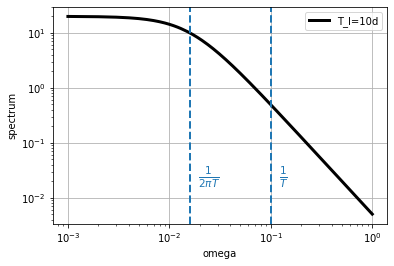

In [8]:
p = dict(omega=dict(bounds=(1e-3*rad,1e0*rad), N=1000))
hdl = u.plot_spectrum(eval_kwargs=p,label='T_l=10d', color='k')


add_omegas(hdl[0].axes, 
           [(1/u.p_values["T"], r"$\frac{1}{T}$"),
            (1/u.p_values["T"]/rad, r"$\frac{1}{2\pi T}$"),
           ],
          )

if print_figs:
    plt.savefig('figs/overview_low_spectrum.png')

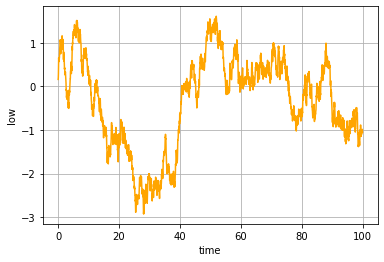

In [9]:
u_syn = u.generate_tseries(seed=0).persist()
u_syn.plot(color='orange')
plt.grid()

if print_figs:
    plt.savefig('figs/overview_low_tseries.png')

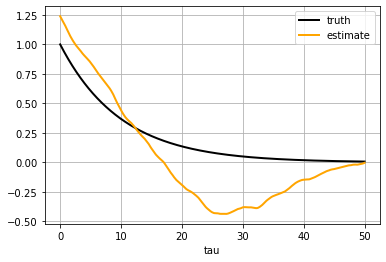

In [10]:
# statistical estimate
ds = (ts
      .correlate(u_syn, u_syn) #, maxlag=30
      .rename('autocorrelation')
      .to_dataset()
      .rename({'lags': 'tau'})
     )
# true autocorrelation
ds['true_autocorrelation'] = u.evaluate_autocorrelation(tau=ds.tau)

fig, ax = plt.subplots(1,1)
ds['true_autocorrelation'].plot(ax=ax, color='k', lw=2, label='truth')
ds['autocorrelation'].plot(ax=ax, color='orange', lw=2, label='estimate')
ax.grid()
ax.legend()
ax.set_ylabel(None)

if print_figs:
    plt.savefig('figs/overview_low_autocorrelation.png')

---

## High frequency signal

In [11]:
p = dict(Us=1., U=1., T=10., sigma=2.*np.pi*2.)
u = hf.high_frequency_signal(parameters_values=p)

In [12]:
u.autocorrelation

U**2*exp(-tau/T)*cos(sigma*tau)/2 + U_s**2*cos(sigma*tau)/2

In [13]:
u.spectrum

T*U**2*(T**2*(omega**2 + sigma**2) + 1)/(T**4*(-omega**2 + sigma**2)**2 + 2*T**2*(omega**2 + sigma**2) + 1) + pi*U_s**2*(DiracDelta(-omega + sigma) + DiracDelta(omega + sigma))/2

In [15]:
# check Parseval: !!! 2 pi factor required
from sympy import oo, pi
_E = u.spectrum.subs({u.p["sigma"]: 2/u.p["T"]}) # hack, required (atan issues with sympy)
_I = _E.integrate((u.omega, 0, oo)) *2 /2/pi
_I.simplify()

U**2/2 + U_s**2/2

In [15]:
# value at central frequency and within the limit of large (Txsigma)
u.spectrum.subs({u.omega: u.p["sigma"]}).limit(u.p["sigma"], oo)

T*U**2/2 + pi*U_s**2*DiracDelta(0)/2

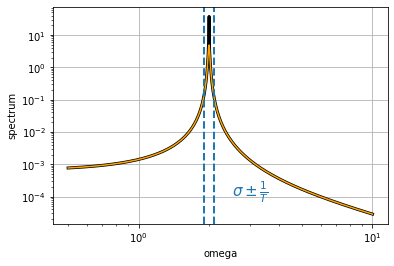

In [16]:
_omega = dict(bounds=(5*1e-1*rad,1e1*rad), N=1000)

fig, ax = plt.subplots(1, 1)

plt_kwargs = dict(xscale="log", yscale="log")

E = u.evaluate_spectrum(omega=_omega)
E.plot(ax=ax, color="k", lw=3, **plt_kwargs)

E = u.evaluate_spectrum(omega=_omega, Us=0.)
E.plot(ax=ax, color="orange", lw=1.5, **plt_kwargs)

add_omegas(ax, [(u.p_values["sigma"]/rad-1/u.p_values["T"], ""),
                (u.p_values["sigma"]/rad+1/u.p_values["T"], r"$\sigma\pm\frac{1}{T}$"),
               ], y=1e-4)
#add_omegas(ax, [(u.p_values["sigma"]/rad+1/u.p_values["T"], r"$\sigma+\frac{1}{T}$"), ], y=1e-4)

ax.grid()

if print_figs:
    plt.savefig('figs/overview_high_spectrum.png')

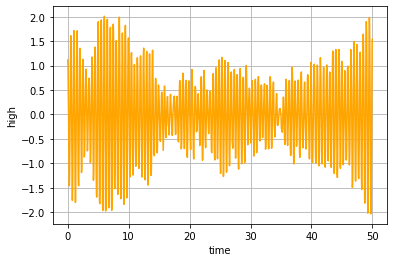

In [17]:
#u_syn = u.generate_tseries(seed=0).persist()
#u_syn.where(u_syn.time<40).plot(color='orange')

_p = dict(**p)
#_p["Us"]=0

u_syn = u.generate_tseries(params=_p, seed=0).persist()
#u_syn.plot(color='orange')
u_syn.where(u_syn.time<50).plot(color='orange')
plt.grid()

if print_figs:
    plt.savefig('figs/overview_high_tseries.png')

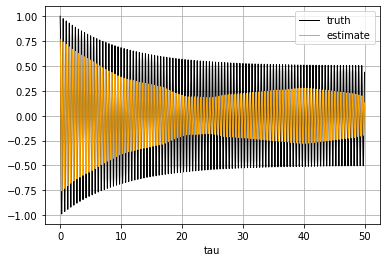

In [18]:
# statistical estimate
ds = (ts
      .correlate(u_syn, u_syn) # maxlag=10
      .rename('autocorrelation')
      .to_dataset()
      .rename({'lags': 'tau'})
     )
# true autocorrelation
ds['true_autocorrelation'] = u.evaluate_autocorrelation(tau=ds.tau, 
                                                        sigma=u.p_values['sigma'],
                                                       )
# should not have to pass sigma above ...

fig, ax = plt.subplots(1,1)
ds['true_autocorrelation'].plot(ax=ax, color='k', lw=1, label='truth')
ds['autocorrelation'].plot(ax=ax, color='orange', lw=1, label='estimate')
ax.grid()
ax.legend()
ax.set_ylabel(None)

if print_figs:
    plt.savefig('figs/overview_high_autocorrelation.png')

Note that the stationary autocorrelation will decrease linearly to half its theoretical value with prescription of `maxlag`.

Prescribing `maxlag` seems to have an adverse effect on a low-frequency or nonstationary component. 
The variance of the signals varies with maxlag for example.
To be verified/investigated

For now we decide no to use `maxlag`. 
If a fit were to be performed, one would have to accound for the linear decrease of the stationary component.

---
## low + high

In [19]:
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal(stationary=True)
u = hf.add(u_low, u_high, labels=['low', 'high'])

In [20]:
u.autocorrelation

U_high**2*exp(-tau/T_high)*cos(sigma_high*tau)/2 + U_low**2*exp(-tau/T_low) + U_s_high**2*cos(sigma_high*tau)/2

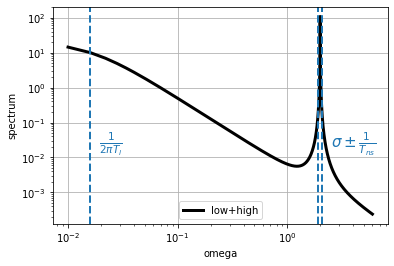

In [22]:
p_values = {**{p:1. for p in u.p if p[0]=='U'},
            **{p:10. for p in u.p if p[0]=='T'},
            
            "sigma_high": 2.*rad,
            "omega": dict(N=1000),
           }

hdl = u.plot_spectrum(eval_kwargs=p_values, 
                label='low+high',
                color='k',
                #add_legend=False,
               )

add_omegas(hdl[0].axes, 
           [(1/p_values["T_low"]/rad, r"$\frac{1}{2\pi T_l}$"),
            (p_values["sigma_high"]/rad-1/p_values["T_high"], ""),
            (p_values["sigma_high"]/rad+1/p_values["T_high"], r"$\sigma\pm\frac{1}{T_{ns}}$"),
           ],
          )


if print_figs:
    plt.savefig('figs/overview_lowhigh_spectrum.png')